# 0. Load dependencies and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import *
import warnings

warnings.filterwarnings('ignore')
wlsubjects = [114, 115, 127, 135, 136, 139, 141, 142]

# Set path to dataframe directory
df_dir = "../../data/dataframes/"

### Load necessary dataframes

In [2]:
# Load fits
suffix = 'target-aligned_V1-LO1'

vox_fname = os.path.join(df_dir, "interstellar_voxelwise_data_%s.tsv" % suffix)
vm_fname = os.path.join(df_dir, "interstellar_vonmises_fits_%s.tsv" % suffix)
boot_name = os.path.join(df_dir, "parf_params_boots_%s.tsv" % suffix)
norm_name = os.path.join(df_dir, "interstellar_norm.tsv")

 
vm_fits = pd.read_csv(vm_fname, sep = '\t', index_col = 0)
boot_fits = pd.read_csv(boot_name, sep = '\t', index_col = 0)
interstellar_norm = pd.read_csv(norm_name, sep = '\t', index_col = 0)


The voxel dataframe is a little over 6GB. It's then processed by norm_group().
The output of this is preloaded in interstellar_norm above. If you want to take a look at the voxelwise data, you can run the below block of code to load it in. This block of code also runs norm_group() on the voxelwise data to compute 'interstellar_norm'. See interstellar.py for 'norm_group' and other custom functions.

In [3]:
# Uncomment the below code if you want to load the voxel data set and run norm_group() on it.

# voxels = pd.read_csv(vox_fname, sep = '\t', index_col = 0)
# interstellar_norm = norm_group(voxels)

# 1. Figure 3a
- Load data fits an bootstrapped fits
- Load binned and normalized data
- Compute confidence intervals for each ROI and each Condition from bootstrapped fits
- Plot the data fits, confidence intervals, and the binned data for each ROI and Condition

In [4]:
# Get fits and structure data
theta_range = np.linspace(-np.pi, np.pi, 361)

# The labels of each ROI 
roi_labels = ["V1", "V2", "V3", "V4", "V3ab", "IPS0", "LO1"]

# The order we want to plot the ROIs in
rois = ["V1", "V2", "V3", "V4", "LO1", "V3ab", "IPS0"]

# Assign a new column containing the roi labels to the data fits and bootstrap fits
vm_fits['roi_labels'] = [roi_labels[int(l-1)] for l in vm_fits.roi.values]
boot_fits['roi_labels'] = [roi_labels[int(l-1)] for l in boot_fits.roi.values]

# Define confidence interval for bootstraps
conf_interval = [16, 84]

# Error bands 
EB = {}

# Von Mises 
VMS = {}

# For each roi x condition, generate the von mises curve and its confidence interval
for i, row in vm_fits.iterrows():
    # Subset data
    vm = diff_vonmises(theta_range, row['loc'], row.kappa1, row.scale1, row.kappa2, row.scale2)
    # ax_data = interstellar_norm.query('task == "%s" & roi == %d' % (row.task, row.roi))

    # Compute bootstrap intervals
    bfits = []
    b = boot_fits.query('task == "%s" & roi == %d' % (row.task, row.roi))
    for i in np.arange(boot_fits.n_boot.nunique()):
        l, k, s, k2, s2 = b.query("n_boot == @i").iloc[0][['loc', 'kappa1', 'scale1', 'kappa2', 'scale2']]
        yhat = diff_vonmises(theta_range, l, k, s, k2, s2)
        bfits.append(yhat)
    bfits=np.vstack(bfits)
    err_bands = np.nanpercentile(bfits, conf_interval, axis=0)

    key = "%s_%s" % (row.roi_labels, row.task)
    EB[key] = err_bands
    VMS[key] = vm



### Plot Spatial tuning curves for Figure 3a

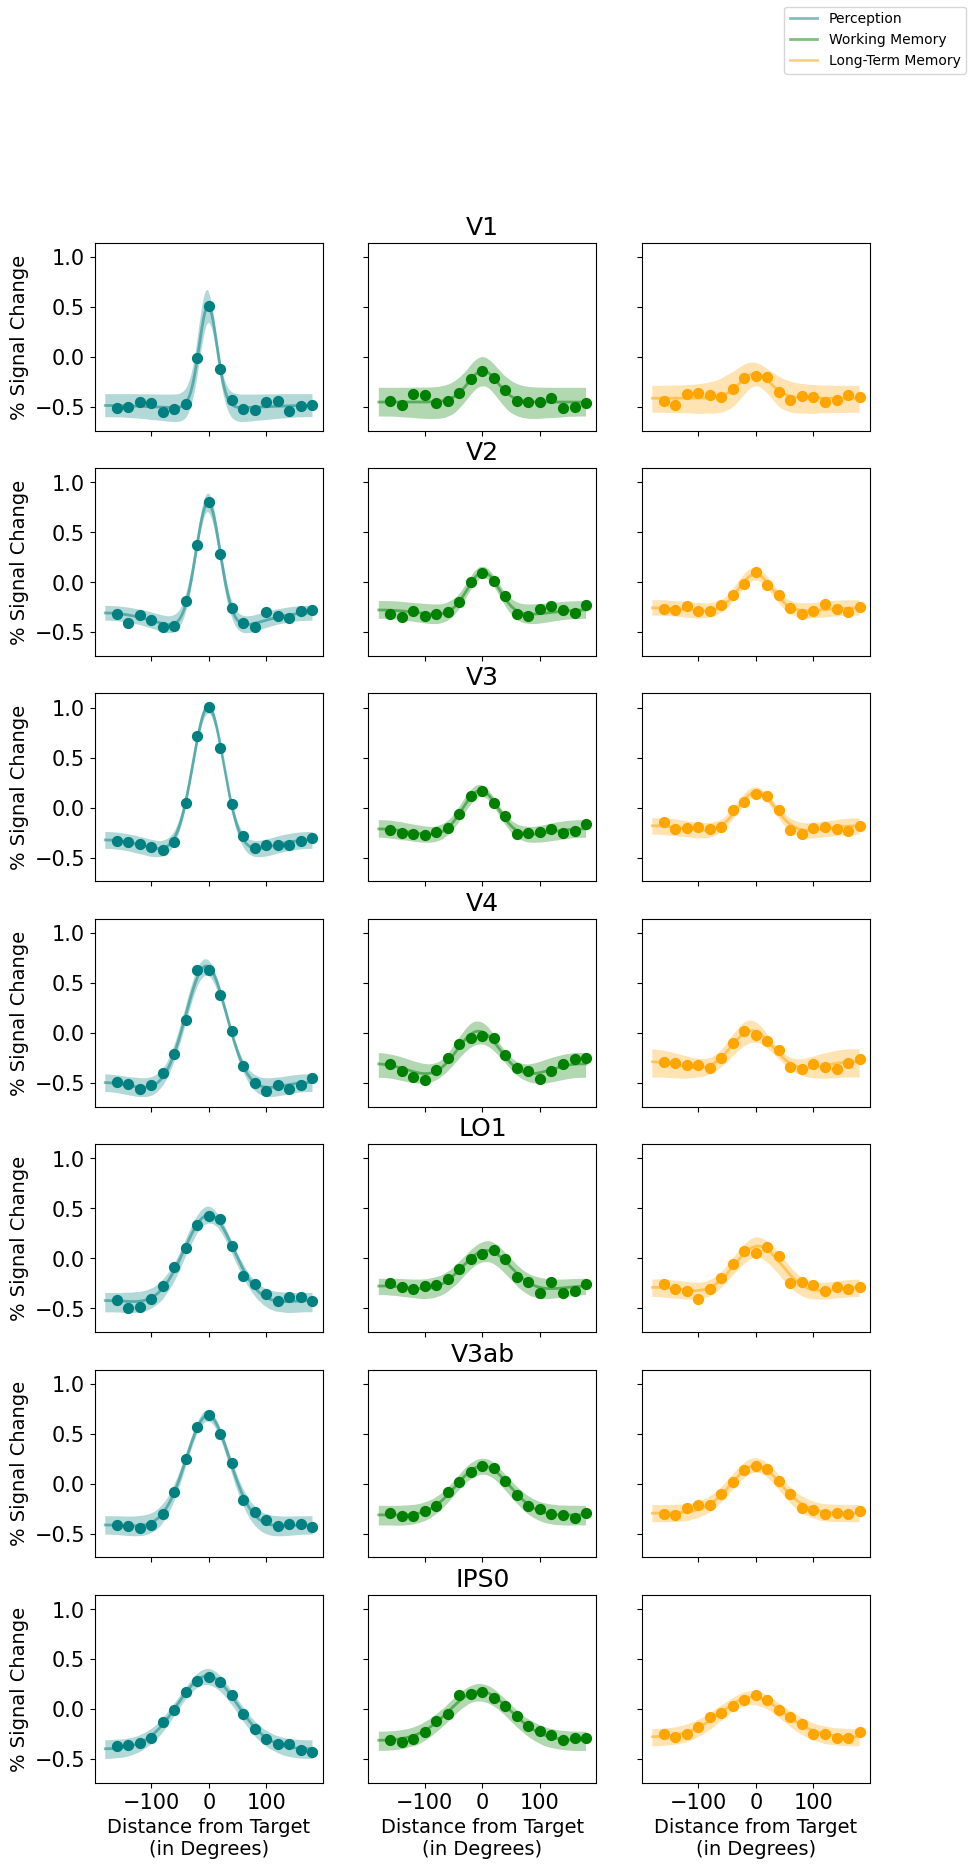

In [5]:
# Define figure subplots
fig, axs = plt.subplots(nrows = vm_fits.roi.nunique(), ncols = vm_fits.task.nunique(), 
                        sharex = True, sharey = True, figsize = [8, 8])

# For each ROI and each condition, plot the 1D polar angle response functions 
# and their bootstrapped confidence intervals
for i, row in vm_fits.iterrows():
    # Index into appropriate axes
    r = rois.index(row.roi_labels)
    c = list(task_colors.keys()).index(row.task)

    ax = axs[r, c]
    
    # Subset data
    ax_data = interstellar_norm.query('task == "%s" & roi == %d' % (row.task, row.roi))

    key = "%s_%s" % (row.roi_labels, row.task)
    err_bands = EB[key]
    vm = VMS[key]

    # Plot the curves
    if row.task == 'perception': 
        p, = ax.plot(np.rad2deg(theta_range), vm, color = task_colors[row.task], 
                    lw=2, alpha = 0.5, label = "Perception")
    if row.task == 'wm': 
        wm,  = ax.plot(np.rad2deg(theta_range), vm, color = task_colors[row.task], 
                    lw=2, alpha = 0.5, label = "Working Memory")
    if row.task == 'ltm': 
        ltm,  = ax.plot(np.rad2deg(theta_range), vm, color = task_colors[row.task], 
                    lw=2, alpha = 0.5, label = "Long-Term Memory")
    
    # Plot the binned data on top as scatter points
    ax.scatter(ax_data.ang_dist_bin, ax_data.beta_adj, color = task_colors[row.task], s = 50)
    ax.tick_params(axis='both', which='major', labelsize=15)
    if c == 0: 
        ax.set_ylabel("% Signal Change", size = 14)
    if r == vm_fits.roi.nunique()-1: 
        ax.set_xlabel("Distance from Target\n(in Degrees)", size = 14)
    if c == 1:
        ax.set_title(row.roi_labels, size = 18)

    # Plot boostrapped conf intervals
    ax.fill_between(np.rad2deg(theta_range), *err_bands, facecolor=task_colors[row.task], alpha=0.3)

# Customization
plt.gcf().set_size_inches(10, 20)
fig.legend(handles = [p, wm, ltm], loc ='upper right')

# 2. Figure 3b

- Plot the parameter estimates (peak location, amplitude, full width at half max) across measured visual maps.
- Plot the 68% and 95% confidence intervals for each estimate

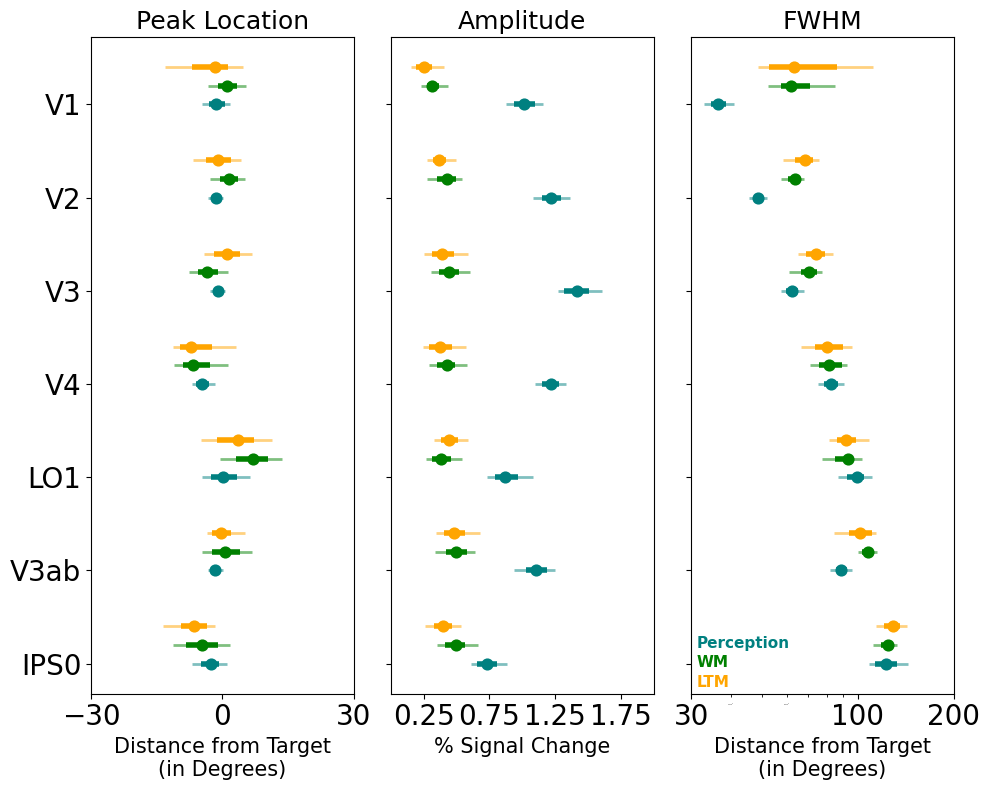

In [7]:
# Hierarchical ROI Analyses
# Define subplots
fig, axes = plt.subplots(1, 3, figsize = (10, 8), sharey = True)

# Make a copy of Von Mises fits to work with
fits = vm_fits.copy()
fits['loc'] = np.degrees(fits['loc'])

# Set some plotting parameters
metrics = ['loc', 'amp', 'fwhm']
lims = {
    'loc': [-30, 30],
    'amp': [0, 2],
    'fwhm': [30, 200]
}
colors = {
    'perception': 'teal',
    'wm': 'green',
    'ltm': 'orange'
}
xticklocs = {
    'loc': [-30, 0, 30],
    'amp': [0, 2],
    'fwhm': [30, 200]   
}
tasks = list(colors.keys())

# Subplot for each metric, colored by condition (task)
for task, metric in itertools.product(tasks, metrics):
    ax = axes[metrics.index(metric)]
    offset = list(task_colors.keys()).index(task) * .2
    data = fits[fits.task == task]
    x = data[metric]
    y = [rois.index(label)+1 - offset for label in data.roi_labels]

    # Compute 95% and 68% confidence intervals using bootstrapped fits
    bfits = []
    for roi in data.roi:
        boot_metric = boot_fits.query('task == "%s" & roi == %0.01f' % (task, roi))[metric]
        bfits.append(boot_metric)
    bfits=np.vstack(bfits)
    err_bands1 = np.nanpercentile(bfits, [16, 84], axis=1)
    err_bands2 = np.nanpercentile(bfits, [2.5, 97.5], axis=1)
    if metric == 'loc': 
        err_bands1 = np.degrees(err_bands1)
        err_bands2 = np.degrees(err_bands2)
    lower1, upper1 = err_bands1[0, :], err_bands1[1, :]
    lower2, upper2 = err_bands2[0, :], err_bands2[1, :]
    
    # Plot parameter estimates as scatter points colored by condition
    ax.scatter(x, y, c = colors[task], s = 60)

    # Plot error bars for 68% (thin line) and 95% (thick line) confidence intervals
    ax.errorbar(x, y, xerr = [x - lower1, upper1 - x], elinewidth = 4, c = task_colors[task], fmt = 'o', alpha = 1)
    ax.errorbar(x, y, xerr = [x - lower2, upper2 - x], elinewidth = 2, c = task_colors[task], fmt = 'o', alpha  = 0.5)
    
    # Aesthetics
    ax.set_xlim(lims[metric])
    ax.invert_yaxis()
    
    ax.set_yticks([1, 2, 3, 4, 5, 6, 7])
    ax.set_yticklabels(rois)

    if metric == "fwhm":
        ax.set_xscale('log')
        ax.set_xticks([30, 100, 200])
        ax.set_xticklabels([30, 100, 200])
        ax.set_title("FWHM", size = 18)
        ax.set_xlabel("Distance from Target\n(in Degrees)", size = 15)
    elif metric == 'amp':
        ax.set_xticks([ 0.25, .75, 1.25, 1.75])
        ax.set_title('Amplitude', size = 18)
        ax.set_xlabel("% Signal Change", size = 15)
        # ax.set_xticklabels([30, 100, 200])
    elif metric == 'loc':
        ax.set_xticks(xticklocs['loc'])
        ax.set_title("Peak Location", size = 18)
        ax.set_xlabel("Distance from Target\n(in Degrees)", size = 15)
        
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=0)

# Legend
i = 0
for t, c in task_colors.items():
    i-=0.03
    if t == 'ltm': 
        s = "LTM"
    elif t == 'wm': 
        s = "WM"
    else:
        s = "Perception"
    ax.text(x = 0.02, y = 0.1+i, s = s, horizontalalignment = 'left', transform = ax.transAxes, 
            size = 11, c = c, fontweight = 'bold')

plt.tight_layout()


In [ ]:
# Save figure
save_dir = "images"
plt.savefig(os.path.join(save_dir, "fig3.pdf") , transparent = True)